# **TRABAJO DE FIN DE MASTER - MASTER EN INTELIGENCIA ARTIFICIAL**
**María Soledad Murias Palomer**

El objetivo de este trabajo es crear un modelo que permita predecir la venta futura por tienda de una serie de productos y, a partir de ella, optimizar el inventario de cada tienda dadas ciertas restricciones de espacio y reposición.

El Notebook 5 realiza sugerencias de políticas de inventario usando dos modelos: EOQ y algoritmo genético. Para ambas metodologías se calculan diferentes costos para poder compararlas y se grafica la evolución diaria del inventario por local.

In [ ]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
import random
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## PRPARACIÓN DE DATOS



In [ ]:
import xgboost as xgb

model_xgb_loaded = xgb.Booster()
model_xgb_loaded.load_model("xgboost_model.json")

file1 = "forecast.csv"
df = pd.read_csv(file1)

In [ ]:
cliente_test = df['Cliente']
cluster_test = df['New_Cluster']
fecha_test = df['Fecha']
precio = df['PrecioUnit']
uns_test = df['Uns']
X_test = df.drop(columns=['Cliente','New_Cluster','Uns'])
X_test.set_index('Fecha', inplace=True)
X_test.head()

,Dia Sem,Sem del año,PrecioUnit,Feriado_FERIADO,Feriado_IRRENUNCIABLE,Feriado_NORMAL,Evento_DIAMADRE,Evento_DIAPADRE,Evento_DIECIOCHO,Evento_NAVIDAD,...,New_Cluster_GUANTE_ZAPATO_ZAPATILLA_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO,New_Cluster_GUANTE_ZAPATO_ZAPATO_CASUAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_CASUAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_ESCOLAR,New_Cluster_GUANTE_ZAPATO_ZAPATO_FORMAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_FORMAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_INFORMAL_CT,New_Cluster_GUANTE_ZAPATO_ZAPATO_INFORMAL_ST,New_Cluster_GUANTE_ZAPATO_ZAPATO_OUTDOOR
Fecha,,,,,,,,,,,,,,,,,,,,,
2025-01-02,4,1,36126.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02,4,1,5874.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02,4,1,34439.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02,4,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-02,4,1,54613.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Usar el modelo cargado para predicciones
dtest = xgb.DMatrix(X_test)
predictions = model_xgb_loaded.predict(dtest)
uns_pred = pd.DataFrame(predictions, columns=['Uns'])

In [ ]:
# Calculamos el precio promedio agrupado para calcular la venta perdida
forecast = pd.concat([fecha_test, cliente_test, cluster_test, precio, uns_test], axis=1)
forecast['Venta'] = forecast['PrecioUnit'] * forecast['Uns']
forecast = forecast.drop(columns=['PrecioUnit'])
forecast = forecast.groupby(["Fecha", "Cliente", "New_Cluster"], as_index=False)[["Uns", "Venta"]].sum()
forecast['PrecioUnit'] = forecast['Venta'] / forecast['Uns']
forecast["PrecioUnit"] = forecast["PrecioUnit"].replace([np.inf, -np.inf], np.nan)  # Reemplazar infinitos por NaN
forecast["PrecioUnit"].fillna(0, inplace=True)
forecast.sort_values(by=["Fecha", "Cliente"], ascending=[True, True], inplace=True)

In [ ]:
forecast.head()

,Fecha,Cliente,New_Cluster,Uns,Venta,PrecioUnit
0,2025-01-02,DUAL MALL APUMANQUE,GACEL_BALLERINA_BALLERINA_VESTIR,1,36126.0,36126.0
1,2025-01-02,DUAL MALL APUMANQUE,GACEL_CALCETIN_CALCETIN,2,11748.0,5874.0
2,2025-01-02,DUAL MALL APUMANQUE,GACEL_CARTERA_CARTERA,4,137756.0,34439.0
3,2025-01-02,DUAL MALL APUMANQUE,GACEL_MOCASIN_MOCASIN_CASUAL,0,0.0,0.0
4,2025-01-02,DUAL MALL APUMANQUE,GACEL_MOCASIN_MOCASIN_VESTIR,2,109226.0,54613.0


In [ ]:
# Capacidad de bodega (vector de largo num_locales)
file2 = "Capacidad bodega.xlsx"
L = pd.read_excel(file2)
L.sort_values(by='Cliente', inplace=True)

# Stock inicial (matriz de dimensiones num_locales x num_categoria)
file3 = "Stock inicial mtx.xlsx"
stock_inicial = pd.read_excel(file3)
stock_inicial.set_index('Cliente', inplace=True)
stock_inicial.sort_values(by='Cliente', inplace=True)

# Coste de transporte (vector de largo num_locales)
file4 = "Costo flete.xlsx"
c = pd.read_excel(file4)
c.sort_values(by='Cliente', inplace=True)

In [ ]:
# Vemos que la cantidad de locales en stock_inicial es mayor que la de L y c, por lo que eliminamos las tiendas sobrantes

print(forecast.shape)
print(stock_inicial.shape)
print(L.shape)
print(c.shape)

(59686, 6)
(69, 119)
(59, 2)
(59, 2)


In [ ]:
clientes_df1 = set(forecast['Cliente'].unique())
clusters_df1 = set(forecast['New_Cluster'].unique())

clientes_df2 = set(stock_inicial.index)  # Asumiendo que los clientes son los índices de df2
clusters_df2 = set(stock_inicial.columns)  # Asumiendo que los clusters son las columnas de df2

cluster_sacar = clusters_df2 - clusters_df1

stock_inicial = stock_inicial.drop(index=stock_inicial.index.difference(clientes_df1))
c = c[c['Cliente'].isin(clientes_df1)]
c.sort_values(by='Cliente', inplace=True)
L = L[L['Cliente'].isin(clientes_df1)]
L.sort_values(by='Cliente', inplace=True)

diferentes = clusters_df1.symmetric_difference(clusters_df2)
stock_inicial = stock_inicial.drop(columns=cluster_sacar)
forecast = forecast[~forecast['New_Cluster'].isin(diferentes)]

In [ ]:
def recalcular_stock(stock_inicial, L):
    # Primero, obtenemos el total de stock actual por cliente (sumamos las categorías)
    total_stock = stock_inicial.sum(axis=1)  # Sumamos las columnas de categorías (sin contar la columna Cliente, que es el índice)

    # Calcular el 80% de la capacidad máxima por cliente
    capacidad_80 = L.set_index('Cliente')['Capacidad'] * 0.80  # 80% de la capacidad para cada cliente

    # Crear una nueva copia de stock_inicial para modificar
    nuevo_stock_inicial = stock_inicial.copy()

    # Recalcular el stock si el total supera el 80% de la capacidad
    for cliente in stock_inicial.index:
        stock_actual = total_stock[cliente]
        capacidad_max = capacidad_80[cliente]

        # Si el stock actual excede el 80% de la capacidad, hacer el ajuste
        if stock_actual > capacidad_max:
            # Calcular el factor de reducción
            factor_reduccion = capacidad_max / stock_actual

            # Ajustar cada categoría proporcionalmente
            for categoria in stock_inicial.columns:
                nuevo_stock_inicial.loc[cliente, categoria] = int(stock_inicial.loc[cliente, categoria] * factor_reduccion)

    return nuevo_stock_inicial

stock_inicial = recalcular_stock(stock_inicial, L)

In [ ]:
num_locales = forecast['Cliente'].nunique()
num_categorias = forecast['New_Cluster'].nunique()
periodo = forecast['Fecha'].nunique()
tiendas = L['Cliente'].unique()  # Lista de tiendas (clientes)

forecast['Fecha'] = pd.to_datetime(forecast['Fecha'])
forecast['t'] = (forecast['Fecha'] - forecast['Fecha'].min()).dt.days  # Convertir las fechas a días (t)
forecast_dict = {(row['Cliente'], row['New_Cluster'], row['t']): (row['Uns'], row['PrecioUnit']) for _, row in forecast.iterrows()}

## OPTIMIZACIÓN DE STOCK
En esta sección se realizará la optimización del inventario de las tiendas dada la venta futura estimada en el notebook previo


### EOQ

In [ ]:
# Definimos una función que calcula la cantidad a reponer dado un forecast de venta y un horizonte de tiempo que se desea provisionar
def EOQ(forecast, horizonte):
    # Estadísticos de venta en el periodo
    mu = forecast.groupby(['Cliente', 'New_Cluster'], as_index=False)['Uns'].mean()
    sigma = forecast.groupby(['Cliente', 'New_Cluster'], as_index=False)['Uns'].std()
    # Demanda total
    D = mu['Uns']
    # Demanda diaria
    D_day = D
    # Lead Time
    LD = 3
    # Cantidad a pedir Q
    Q = D_day * horizonte

    # Nivel de servicio = 95%
    CSL = 0.95

    # Venta promedio en el periodo
    mu_ld = mu['Uns'] * LD / periodo
    # Desv Est de venta en el periodo
    sigma_ld = sigma['Uns'] * math.sqrt(LD /periodo)
    # Calculamos k según el nivel de servicio deseado
    k = round(stats.norm(0, 1).ppf(CSL),2)
    # Punto de reorder
    s = mu.copy()
    s['Reorder'] = mu_ld + k * sigma_ld
    s = s.reset_index()

    s['Reorder'] = s['Reorder'].fillna(0)

    return s, Q

In [ ]:
def stock_diario(forecast):
    # s, Q son diccionarios

    # Obtener el listado de todos los clientes y categorías (New_Cluster)
    clientes = forecast['Cliente'].unique()
    categorias = forecast['New_Cluster'].unique()

    # Convertir stock_inicial a un diccionario para acceso rápido
    stock_inicial_dict = stock_inicial.to_dict(orient='index')  # Clientes como claves y categorías como columnas

    # Inicializar el diccionario de stock_diario
    stock_diario = {}

    # Asignar stock inicial al t=0 en el stock_diario
    for cliente in clientes:
        for categoria in categorias:
            if cliente in stock_inicial_dict and categoria in stock_inicial_dict[cliente]:
                stock_diario[(cliente, categoria, 0)] = stock_inicial_dict[cliente].get(categoria, 0)

    # Calcular el stock diario para cada periodo (t)
    for t in range(1, periodo + 1):
        for cliente in clientes:
            for categoria in categorias:
                # Obtén las ventas diarias (si existen) del forecast
                venta = forecast_dict.get((cliente, categoria, t),(0,0))[0]

                # Calcular el stock del día t
                stock_diario[(cliente, categoria, t)] = stock_diario.get((cliente, categoria, t - 1), 0) - venta

                # Verificar si es día de reabastecimiento y si es necesario enviar stock (según s_dict y Q_dict)
                reorder_point = s_dict.get((cliente, categoria), 0)
                if stock_diario[(cliente, categoria, t)] < reorder_point and t % 7 == 0:
                    reorder_quantity = Q_dict.get((cliente, categoria), 0)
                    stock_diario[(cliente, categoria, t)] += reorder_quantity  # Reabastecer

    return stock_diario

def stock_local_diario(stock_diario):
    # Inicializamos un diccionario para almacenar el stock por cliente
    stock_local_diario = {}

    # Iteramos sobre el diccionario de stock_diario
    for (cliente, categoria, t), stock in stock_diario.items():
        # Aseguramos que la clave cliente exista en el diccionario
        if cliente not in stock_local_diario:
            stock_local_diario[cliente] = np.zeros(periodo + 1)  # Creamos un array de ceros para cada cliente

        # Sumamos el stock por cada cliente y cada período t
        stock_local_diario[cliente][t] += stock

    return stock_local_diario

In [ ]:
# Calculamos el valor del horizonte que minimice el costo del sistema de abastecimiento:
h_opt = 30
costo_opt = 10e100
costo_eoq = []
for h in range(30,0,-1):
    s, Q = EOQ(forecast, h)
    s_dict = s.set_index(['Cliente', 'New_Cluster'])['Uns'].to_dict()
    Q_dict = {(row['Cliente'], row['New_Cluster']): Q[i] for i, row in s.iterrows()}
    stock_diario_opt = stock_diario(forecast)
    stock_local_diario_opt = stock_local_diario(stock_diario_opt)
    stock_df = pd.DataFrame(stock_local_diario_opt, columns=L['Cliente'].unique())
    stock_df = pd.DataFrame(stock_local_diario_opt, columns=L['Cliente'].unique()).T
    stock_df = stock_df.reset_index().rename(columns={"index": "Cliente"})
    stock_df.sort_values(by=['Cliente'], inplace=True)

    # Calculamos el costo del modelo EOQ (reposición + venta perdida + penalización por sobrestock)
    reposiciones = {}  # Diccionario para almacenar la cantidad de reposiciones por Cliente y New_Cluster

    for (cliente, categoria, dia), stock in stock_diario_opt.items():
        if dia == 0:
            continue  # No analizamos el primer día porque no tiene referencia previa

        stock_anterior = stock_diario_opt.get((cliente, categoria, dia - 1), 0)

        # Obtener s y Q desde los diccionarios
        s_val = s_dict.get((cliente, categoria), 0)  # Si no existe, devuelve 0
        Q_val = Q_dict.get(cliente, 0)  # Q solo depende de Cliente

        # Contamos una reposición si el stock subió en al menos Q_val unidades
        if stock > stock_anterior + s_val:
            reposiciones[(cliente, dia)] = reposiciones.get((cliente, dia), 0) + 1

    # Convertir el resultado a DataFrame
    repos_df = pd.DataFrame(reposiciones.items(), columns=['Cliente', 'Reposiciones'])
    # Extraer solo la parte del Cliente (el primer valor de la tupla) en una nueva columna
    repos_df['Cliente_extraido'] = repos_df['Cliente'].apply(lambda x: x[0])
    # Ahora agrupamos solo por 'Cliente_extraido' para contar las repeticiones
    repeticiones_por_cliente = repos_df.groupby('Cliente_extraido')['Reposiciones'].sum().reset_index()
    # Unir con el DataFrame c para obtener el costo de visita
    repeticiones_con_costo = repeticiones_por_cliente.merge(c, left_on='Cliente_extraido', right_on='Cliente', how='left')
    # Calcular el costo total multiplicando las reposiciones por el costo de visita
    repeticiones_con_costo['Costo Total'] = repeticiones_con_costo['Reposiciones'] * repeticiones_con_costo['Costo']
    costo_total = repeticiones_con_costo['Costo Total'].sum()

    # Cálculo de venta perdida
    ventas_perdidas = {}
    for clave, uns in stock_diario_opt.items():
        if uns < 0:  # Filtrar valores negativos de Uns
            precio_unit = forecast_dict.get(clave, (0, 0))[1]  # Obtener PrecioUnit del forecast
            ventas_perdidas[clave] = abs(uns) * precio_unit  # Multiplicar por el precio
    total_venta_perdida = sum(ventas_perdidas.values())

    # Cálculo de penalización por sobrestock
    df_merged = stock_df.merge(L, on='Cliente')
    df_merged['Conteo'] = (df_merged.iloc[:, 1:-1].gt(df_merged['Capacidad'], axis=0)).sum(axis=1)
    resultado = df_merged[['Cliente', 'Conteo']]
    penalizacion_capacidad = df_merged['Conteo'].sum() * 1000000
    costo_aux = costo_total+total_venta_perdida+penalizacion_capacidad

    if costo_aux < costo_opt:
        h_opt = h
        costo_opt = costo_aux
        costo_eoq = [costo_total,total_venta_perdida,penalizacion_capacidad]

In [ ]:
# Mostrar el resultado
print(f"El costo mínimo se alcanza con un hoprizonte de: {h_opt:,.0f}")

El costo mínimo se alcanza con un hoprizonte de: 25


In [ ]:
# Mostrar el costo
print(f"El costo total de reposición del modelo EOQ es: {costo_opt:,.2f}")

El costo total de reposición del modelo EOQ es: 1,001,817,581.52


In [ ]:
print(f"El costo de transporte del modelo EOQ es: {costo_eoq[0]:,.2f}")
print(f"La venta perdida del modelo EOQ es: {costo_eoq[1]:,.2f}")
print(f"La penalización por sobrestock del modelo EOQ es: {costo_eoq[2]:,.2f}")

El costo de transporte del modelo EOQ es: 418,900,000.00
La venta perdida del modelo EOQ es: 551,917,581.52
La penalización por sobrestock del modelo EOQ es: 31,000,000.00


In [ ]:
s, Q = EOQ(forecast, h_opt)
s_dict = s.set_index(['Cliente', 'New_Cluster'])['Uns'].to_dict()
Q_dict = {(row['Cliente'], row['New_Cluster']): Q[i] for i, row in s.iterrows()}
stock_diario_opt = stock_diario(forecast)
stock_local_diario_opt = stock_local_diario(stock_diario_opt)
stock_df = pd.DataFrame(stock_local_diario_opt, columns=L['Cliente'].unique())
stock_df = pd.DataFrame(stock_local_diario_opt, columns=L['Cliente'].unique()).T
stock_df = stock_df.reset_index().rename(columns={"index": "Cliente"})
stock_df.sort_values(by=['Cliente'], inplace=True)

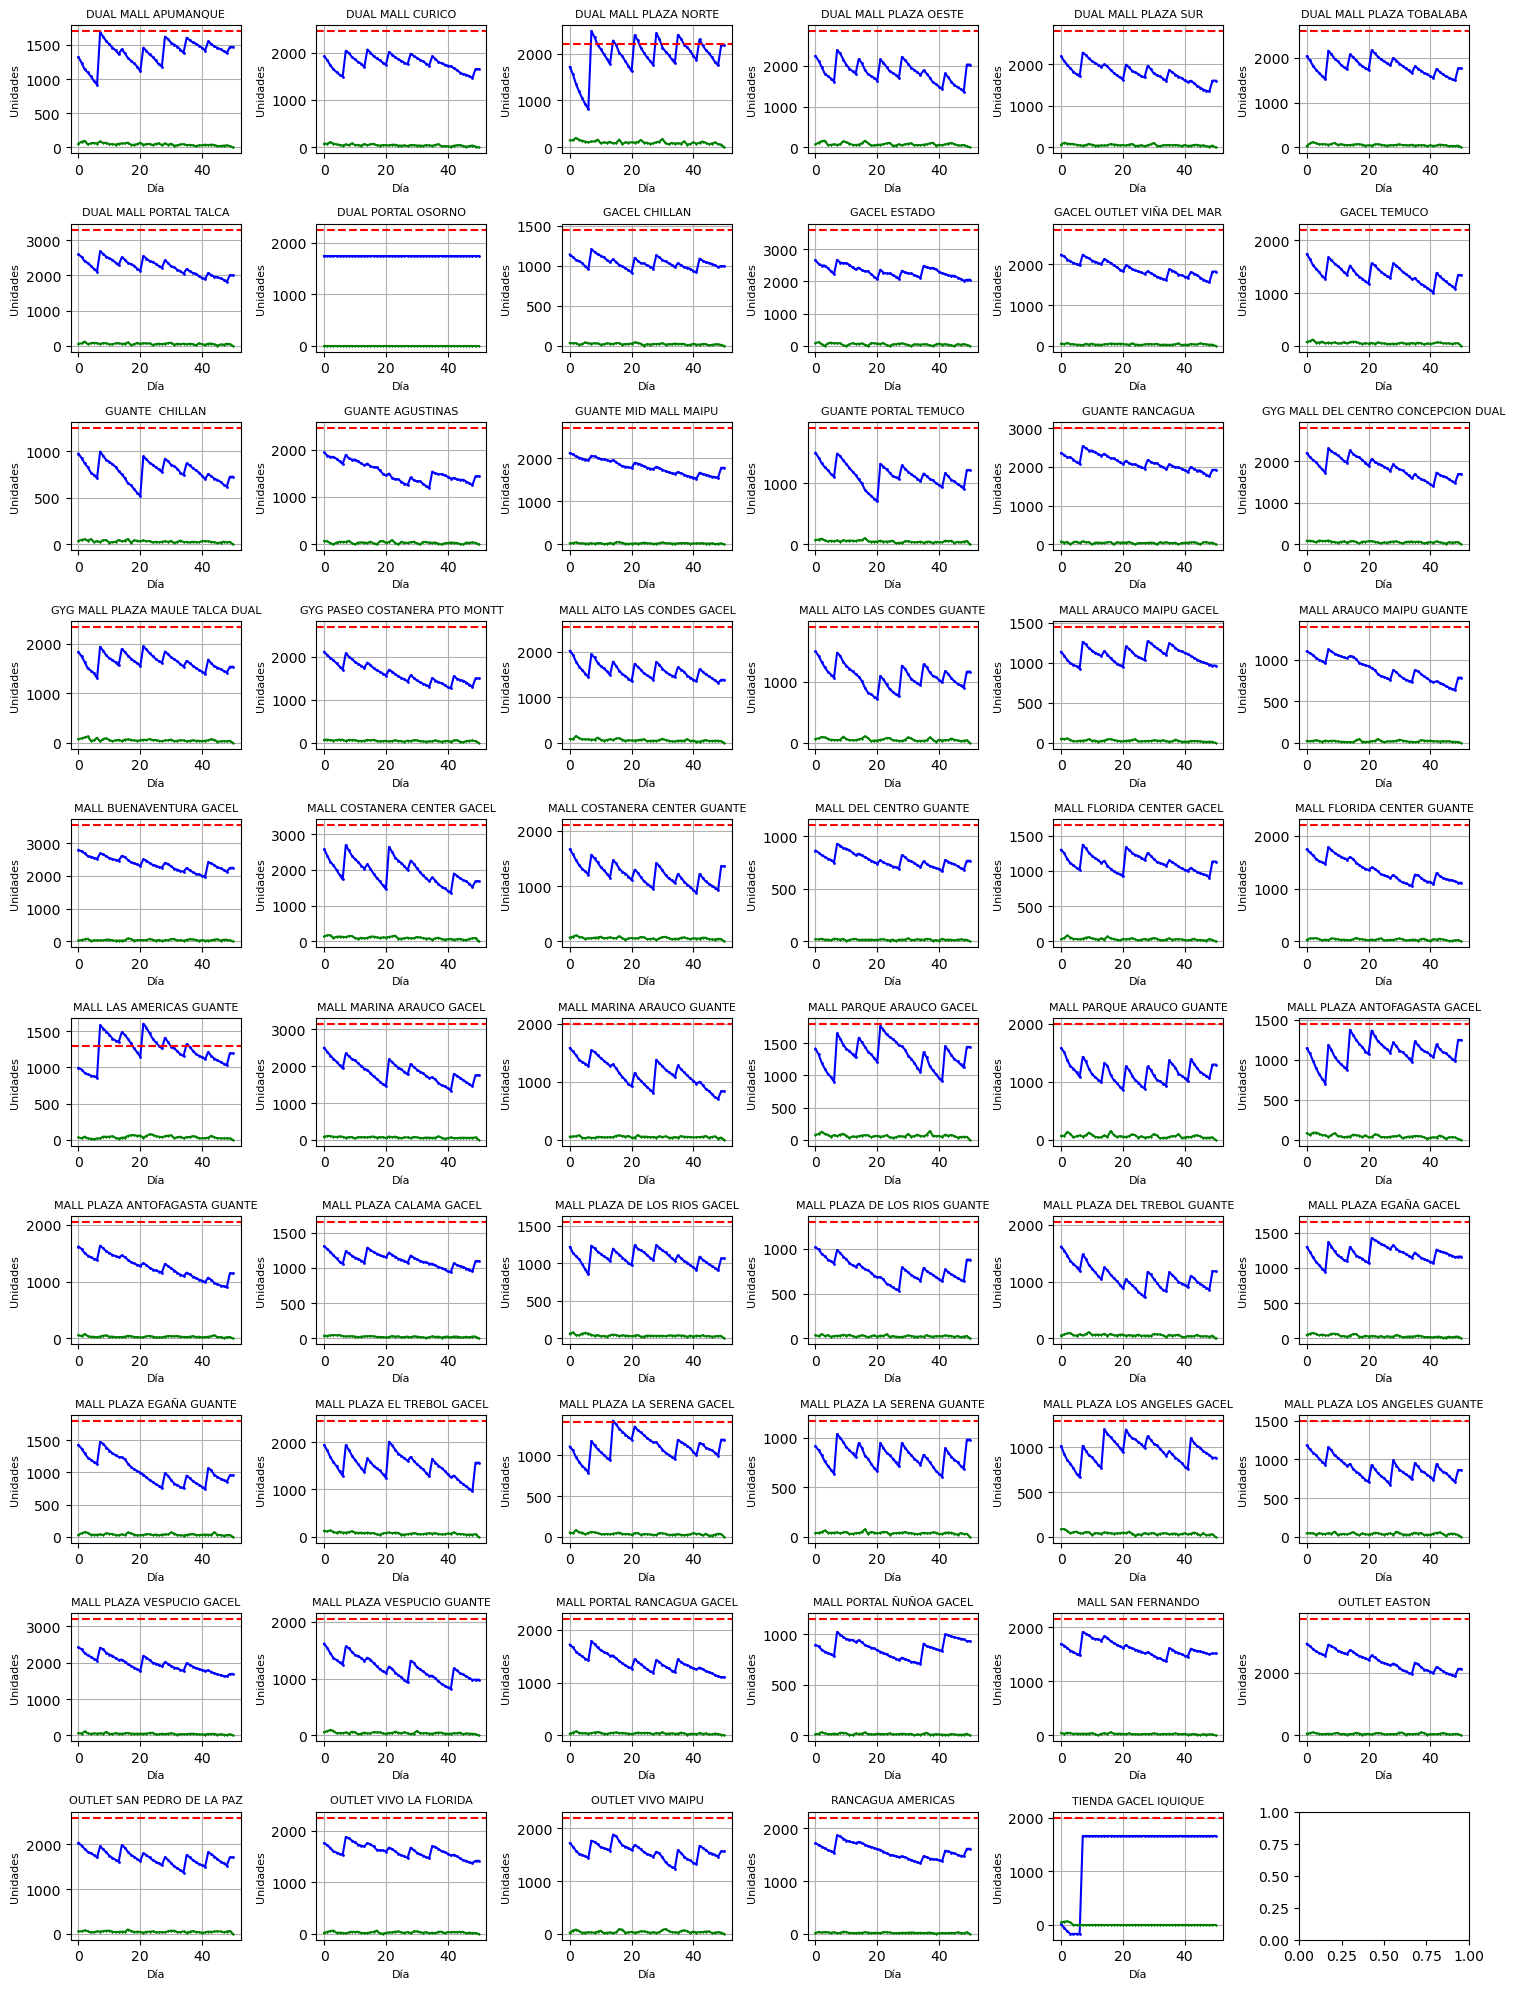

In [ ]:
# Número de filas y columnas para los subgráficos
num_filas = 10  # Puedes ajustar esto según lo que se vea mejor
num_columnas = 6  # Puedes ajustar esto según lo que se vea mejor

# Crear la figura y los subgráficos
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 20))

# Aplanar el array de ejes para acceder a cada uno más fácilmente
axes = axes.flatten()

# Iterar sobre cada tienda y crear el gráfico correspondiente
for idx, local in enumerate(tiendas):
    # Obtener el stock diario para ese cliente de stock_df
    stock_local = stock_df.loc[stock_df['Cliente'] == local].iloc[0, 1:].values  # Accedemos a la fila y las columnas (sin la primera columna)

    # Obtener la capacidad de ese local desde el DataFrame L
    capacidad_local = L[L['Cliente'] == local]['Capacidad'].values[0]

    # Crear los ejes (días del periodo)
    dias = np.arange(periodo + 1)  # Días 0, 1, ..., 30

    # Filtrar las ventas para el cliente específico en forecast
    ventas_local = forecast[forecast['Cliente'] == local]
    ventas_local_diarias = np.zeros(periodo + 1)

    # Sumar las ventas por día (t)
    for t in dias:
        ventas_local_diarias[t] = ventas_local[ventas_local['t'] == t]['Uns'].sum()

    # Seleccionar el subgráfico correspondiente
    ax = axes[idx]

    # Graficar Stock Diario
    ax.plot(dias, stock_local, label='Stock Diario', color='b', marker='o', markersize=1)

    # Línea de Capacidad Máxima
    ax.axhline(capacidad_local, color='r', linestyle='--', label='Capacidad Máxima')

    # Graficar Ventas Diarias
    ax.plot(dias, ventas_local_diarias, label='Ventas Diarias', color='g', marker='x', markersize=1)

    # Configurar el título y etiquetas
    ax.set_title(f"{local}", fontsize=8)
    ax.set_xlabel("Día", fontsize=8)
    ax.set_ylabel("Unidades", fontsize=8)
    #ax.legend(fontsize=8)
    ax.grid(True)

# Ajustar el diseño para que no se superpongan los subgráficos
plt.tight_layout()
plt.savefig("grafico_EOQ.png", dpi=300, bbox_inches='tight')
# Mostrar la figura
plt.show()

### ALGORITMO GENETICO

In [ ]:
L_dict = L.set_index(['Cliente'])['Capacidad'].to_dict()
c_dict = c.set_index(['Cliente'])['Costo'].to_dict()
forecast_dict = {(row['Cliente'], row['New_Cluster'], row['t']): (row['Uns'], row['PrecioUnit']) for _, row in forecast.iterrows()}
stock_inicial_dict = stock_inicial.to_dict(orient='index')
locales = L['Cliente'].unique()
categorias = forecast['New_Cluster'].unique()

In [ ]:
#Evalua la población y devuelve el mejor individuo
def EvaluarPoblacion(poblacion):
  mejor_solucion = []
  mejor_costo = 10e100
  for p in poblacion:
    costo_referencia = sum(funcionObj(p))
    if costo_referencia < mejor_costo:
      mejor_solucion = p
      mejor_costo = costo_referencia
  return mejor_solucion, mejor_costo

# Definimos la función objetivo a minimizar
def funcionObj(solucion):
    visitas, stock_obj = solucion

    costo_visitas = sum(visitas[cliente][dia] * c_dict[cliente] for cliente in visitas for dia in visitas[cliente])

    # Simulación de venta perdida
    venta_perdida, stock_dia = calcular_venta_perdida(solucion)

    # Penalización sobrestock
    stock_local_dia = stock_local_diario(stock_dia)
    stock_df = pd.DataFrame(stock_local_dia, columns=L['Cliente'].unique()).T
    stock_df = stock_df.reset_index().rename(columns={"index": "Cliente"})
    stock_df.sort_values(by=['Cliente'], inplace=True)
    df_merged = stock_df.merge(L, on='Cliente')
    df_merged['Conteo'] = (df_merged.iloc[:, 1:-1].gt(df_merged['Capacidad'], axis=0)).sum(axis=1)
    resultado = df_merged[['Cliente', 'Conteo']]
    penalizacion_capacidad = df_merged['Conteo'].sum() * 1000000

    return [costo_visitas,venta_perdida,penalizacion_capacidad]

# Función para calcular la venta perdida
def calcular_venta_perdida(solucion):
    visitas, stock_obj = solucion

    # Diccionario para almacenar el stock diario, inicializamos con valores de stock_inicial para t=0
    stock_dia = {}
    for cliente in locales:
        for categoria in categorias:
            for dia in range(periodo+1):
                # Asignar un valor inicial para Uns
                stock_dia[cliente,categoria,dia] = 0

    # Asignamos el stock diario en t=0 con el stock_inicial
    for cliente in locales:
        for categoria in categorias:
            stock_dia[cliente,categoria,0] = stock_inicial_dict[cliente][categoria]

    ventas_perdidas = {}
    # Iteración por cada día t (de 1 a periodo)
    for cliente in locales:
        for categoria in categorias:
            # Inicializar precio_unit
            precio_unit = 0
            for t in range(1, periodo):
                # Obtener la venta esperada del forecast
                venta = forecast_dict.get((cliente, categoria, t-1), (0, 0))[0]

                # Calcular el cambio en el stock
                stock_anterior = stock_dia[cliente, categoria, t-1]
                stock_reposicion = max(0, stock_obj[cliente][categoria] - stock_anterior) if visitas[cliente][t] == 1 else 0
                stock_dia[cliente, categoria, t] = stock_anterior - venta + stock_reposicion

                # Cálculo de venta perdida si el stock es negativo
                if stock_dia[cliente, categoria, t] < 0:
                    # Obtener PrecioUnit si no es 0
                    precio_unit_value = forecast_dict.get((cliente, categoria, t-1), (0, 0))[1]
                    if precio_unit_value != 0:
                        precio_unit = precio_unit_value

                    # Calcular la venta perdida
                    ventas_perdidas[(cliente, categoria, t)] = abs(stock_dia[cliente, categoria, t]) * precio_unit

    venta_perdida_total = sum(ventas_perdidas.values())

    return venta_perdida_total, stock_dia

# Definimos función que crea una solución aleatoria
def crear_solucion():
    visitas = {cliente: {dia: 1 if dia % random.randint(5, 10) == 0 else 0 for dia in range(periodo)} for cliente in locales}
    stock_obj = {cliente: {new_cluster: math.floor(Q_dict.get((cliente, new_cluster), 0) * (random.randint(50, 90) / 100)) for new_cluster in categorias} for cliente in locales}

    return [visitas, stock_obj]

#Genera una poblacion inicial de soluciones de tamaño N
def generar_poblacion(N):
    return [crear_solucion() for _ in range(N)]

#Funcion de cruce. Recibe una poblacion(lista de soluciones) y devuelve la población ampliada con los hijos.
# Todos los individuos de la población son selecionados para el cruce(si la población es par)
# Podría aplicarse un proceso previo de selección para elegir los individuos que se desea cruzar.
def Cruzar(poblacion, mutacion):
    poblacion_copia = copy.deepcopy(poblacion)
    poblacion_final = []

    while len(poblacion_copia) > 1:
        padre1, padre2 = random.sample(poblacion_copia, 2)
        poblacion_copia.remove(padre1)
        poblacion_copia.remove(padre2)
        # Generar hijos
        hijos = Descendencia([padre1, padre2], mutacion)
        poblacion_final.extend(hijos)

    return poblacion_final

#Funcion para generar hijos a partir de 2 padres:
def Descendencia(padres,mutacion):
  #La descendencia se hará combinando las matrices de reposición y stock de ambos padres
  visitas1, stock_obj1 = padres[0]
  visitas2, stock_obj2 = padres[1]
  hijo1 =  Factibilizar([visitas1, stock_obj2])
  hijo2 =  Factibilizar([visitas2, stock_obj1])
  return [hijo1,hijo2,Mutar(hijo1,mutacion),Mutar(hijo2,mutacion)]

#Funcion de mutación.
#La mutación consistirá en invertir en la matriz de reposición dos parejas de días
def Mutar(solucion, mutacion):
    if random.random() < mutacion:
        visitas, stock_obj = solucion
        # Seleccionamos dos días aleatorios para mutar
        dias_cambiar = random.sample(range(len(visitas[next(iter(visitas))])), 2)  # Asegura que el índice esté basado en los días
        # Intercambiar los valores de las visitas en esos días
        for cliente in visitas:
            visitas[cliente][dias_cambiar[0]], visitas[cliente][dias_cambiar[1]] = \
            visitas[cliente][dias_cambiar[1]], visitas[cliente][dias_cambiar[0]]
        # Devolver la solución mutada
        sol_fact = Factibilizar([visitas, stock_obj])
        return sol_fact
    else:
        return solucion

# Función factibilizar para asegurar que las soluciones tengan la estructura deseada:
# visitas es binario con 0 y 1
# stock_obj debe ser mayor o igual a cero
def Factibilizar(solucion):
    visitas, stock_obj = solucion
    # Asegurar que visitas solo tenga valores 0 o 1
    visitas = {k: {d: 1 if v != 0 else 0 for d, v in v_dict.items()} for k, v_dict in visitas.items()}
    # Asegurar que stock_obj solo tenga valores >= 0
    stock_obj = {k: {d: max(0, v) for d, v in v_dict.items()} for k, v_dict in stock_obj.items()}
    # Devolver la solución factibilizada como diccionario
    return [visitas, stock_obj]

#Funcion de selección de la población. Recibe como parametro una población y
# devuelve una población a la que se ha eliminado individuos poco aptos(fitness bajo) y para mantener una poblacion estable de N individuos
#Se tiene en cuenta el porcentaje elitismo pasado como párametro
# Para los individuos que no son de la elite podríamos usar una selección de ruleta(proporcional a su fitness)
def Seleccionar(poblacion, N, elitismo):
  #Se ordena la población según el fitness(tamaño del recorrido) en una lista de elementos [costo, solucion]
  poblacion_ordenada = sorted([ [sum(funcionObj(solucion)), solucion] for solucion in poblacion ], key= lambda x:x[0] )

  #Devolvemos elitismo% y el resto se eligen aleatoriamente
  return [x[1] for x in poblacion_ordenada][:int(N*elitismo)]  +   random.sample([x[1] for x in poblacion_ordenada][int(N*elitismo):] , int(N*(1-elitismo))  )

#Funcion principal del algoritmo genetico
def algoritmo_genetico(N, mutacion, elitismo, generaciones):
    poblacion = generar_poblacion(N)
    mejor_solucion = None
    mejor_costo = float('inf')

    for generacion in range(generaciones):
        # Cruce y mutación
        poblacion = Cruzar(poblacion, mutacion)

        # Selección de la población
        poblacion = Seleccionar(poblacion, N, elitismo)

        # Evaluación
        mejor_solucion, mejor_costo = EvaluarPoblacion(poblacion)

        print(f"Generación {generacion} - Mejor Costo: {mejor_costo:,.2f}")

    return mejor_solucion

In [ ]:
solucion = algoritmo_genetico(N=100, mutacion=0.2, elitismo=0.1, generaciones=50)

Generación 0 - Mejor Costo: 1,002,920,932.13
Generación 1 - Mejor Costo: 1,004,250,325.18
Generación 2 - Mejor Costo: 655,566,502.70
Generación 3 - Mejor Costo: 676,522,350.22
Generación 4 - Mejor Costo: 662,355,155.73
Generación 5 - Mejor Costo: 637,561,378.67
Generación 6 - Mejor Costo: 617,766,771.49
Generación 7 - Mejor Costo: 576,355,833.00
Generación 8 - Mejor Costo: 564,494,190.50
Generación 9 - Mejor Costo: 596,370,877.82
Generación 10 - Mejor Costo: 564,494,190.50
Generación 11 - Mejor Costo: 581,207,766.87
Generación 12 - Mejor Costo: 574,844,517.03
Generación 13 - Mejor Costo: 576,355,833.00
Generación 14 - Mejor Costo: 532,404,669.89
Generación 15 - Mejor Costo: 532,404,669.89
Generación 16 - Mejor Costo: 526,933,759.18
Generación 17 - Mejor Costo: 526,933,759.18
Generación 18 - Mejor Costo: 526,933,759.18
Generación 19 - Mejor Costo: 526,933,759.18
Generación 20 - Mejor Costo: 526,646,979.09
Generación 21 - Mejor Costo: 526,933,759.18
Generación 22 - Mejor Costo: 514,929,8

In [ ]:
# Evaluar las funciones de costo con la solucion EOQ
#solucion = crear_solucion()
visitas, stock_obj = solucion
visita_df = pd.DataFrame(visitas)
stock_obj_df = pd.DataFrame(stock_obj)
visita_df.to_csv("visitas.csv")
stock_obj_df.to_csv("stock_obj.csv")
[costo_visitas,venta_perdida,penalizacion_capacidad] = funcionObj(solucion)
costo_gen = costo_visitas+venta_perdida+penalizacion_capacidad
print(f"El costo total del modelo EOQ es: {costo_gen:,.2f}")
print(f"El costo de transporte del modelo EOQ es: {costo_visitas:,.2f}")
print(f"La venta perdida del modelo EOQ es: {venta_perdida:,.2f}")
print(f"La penalización por sobrestock del modelo EOQ es: {penalizacion_capacidad:,.2f}")

El costo total del modelo EOQ es: 369,374,822.99
El costo de transporte del modelo EOQ es: 97,500,000.00
La venta perdida del modelo EOQ es: 91,874,822.99
La penalización por sobrestock del modelo EOQ es: 180,000,000.00


In [ ]:
venta_perdida_total, stock_dia = calcular_venta_perdida(solucion)

In [ ]:
# Número de filas y columnas para los subgráficos
num_filas = 10  # Puedes ajustar esto según lo que se vea mejor
num_columnas = 6  # Puedes ajustar esto según lo que se vea mejor

# Crear diccionario con stock diario por local
stock_tienda = stock_local_diario(stock_dia)
stock_df = pd.DataFrame(stock_tienda, columns=L['Cliente'].unique())
stock_df = pd.DataFrame(stock_tienda, columns=L['Cliente'].unique()).T
stock_df = stock_df.reset_index().rename(columns={"index": "Cliente"})
stock_df.sort_values(by=['Cliente'], inplace=True)

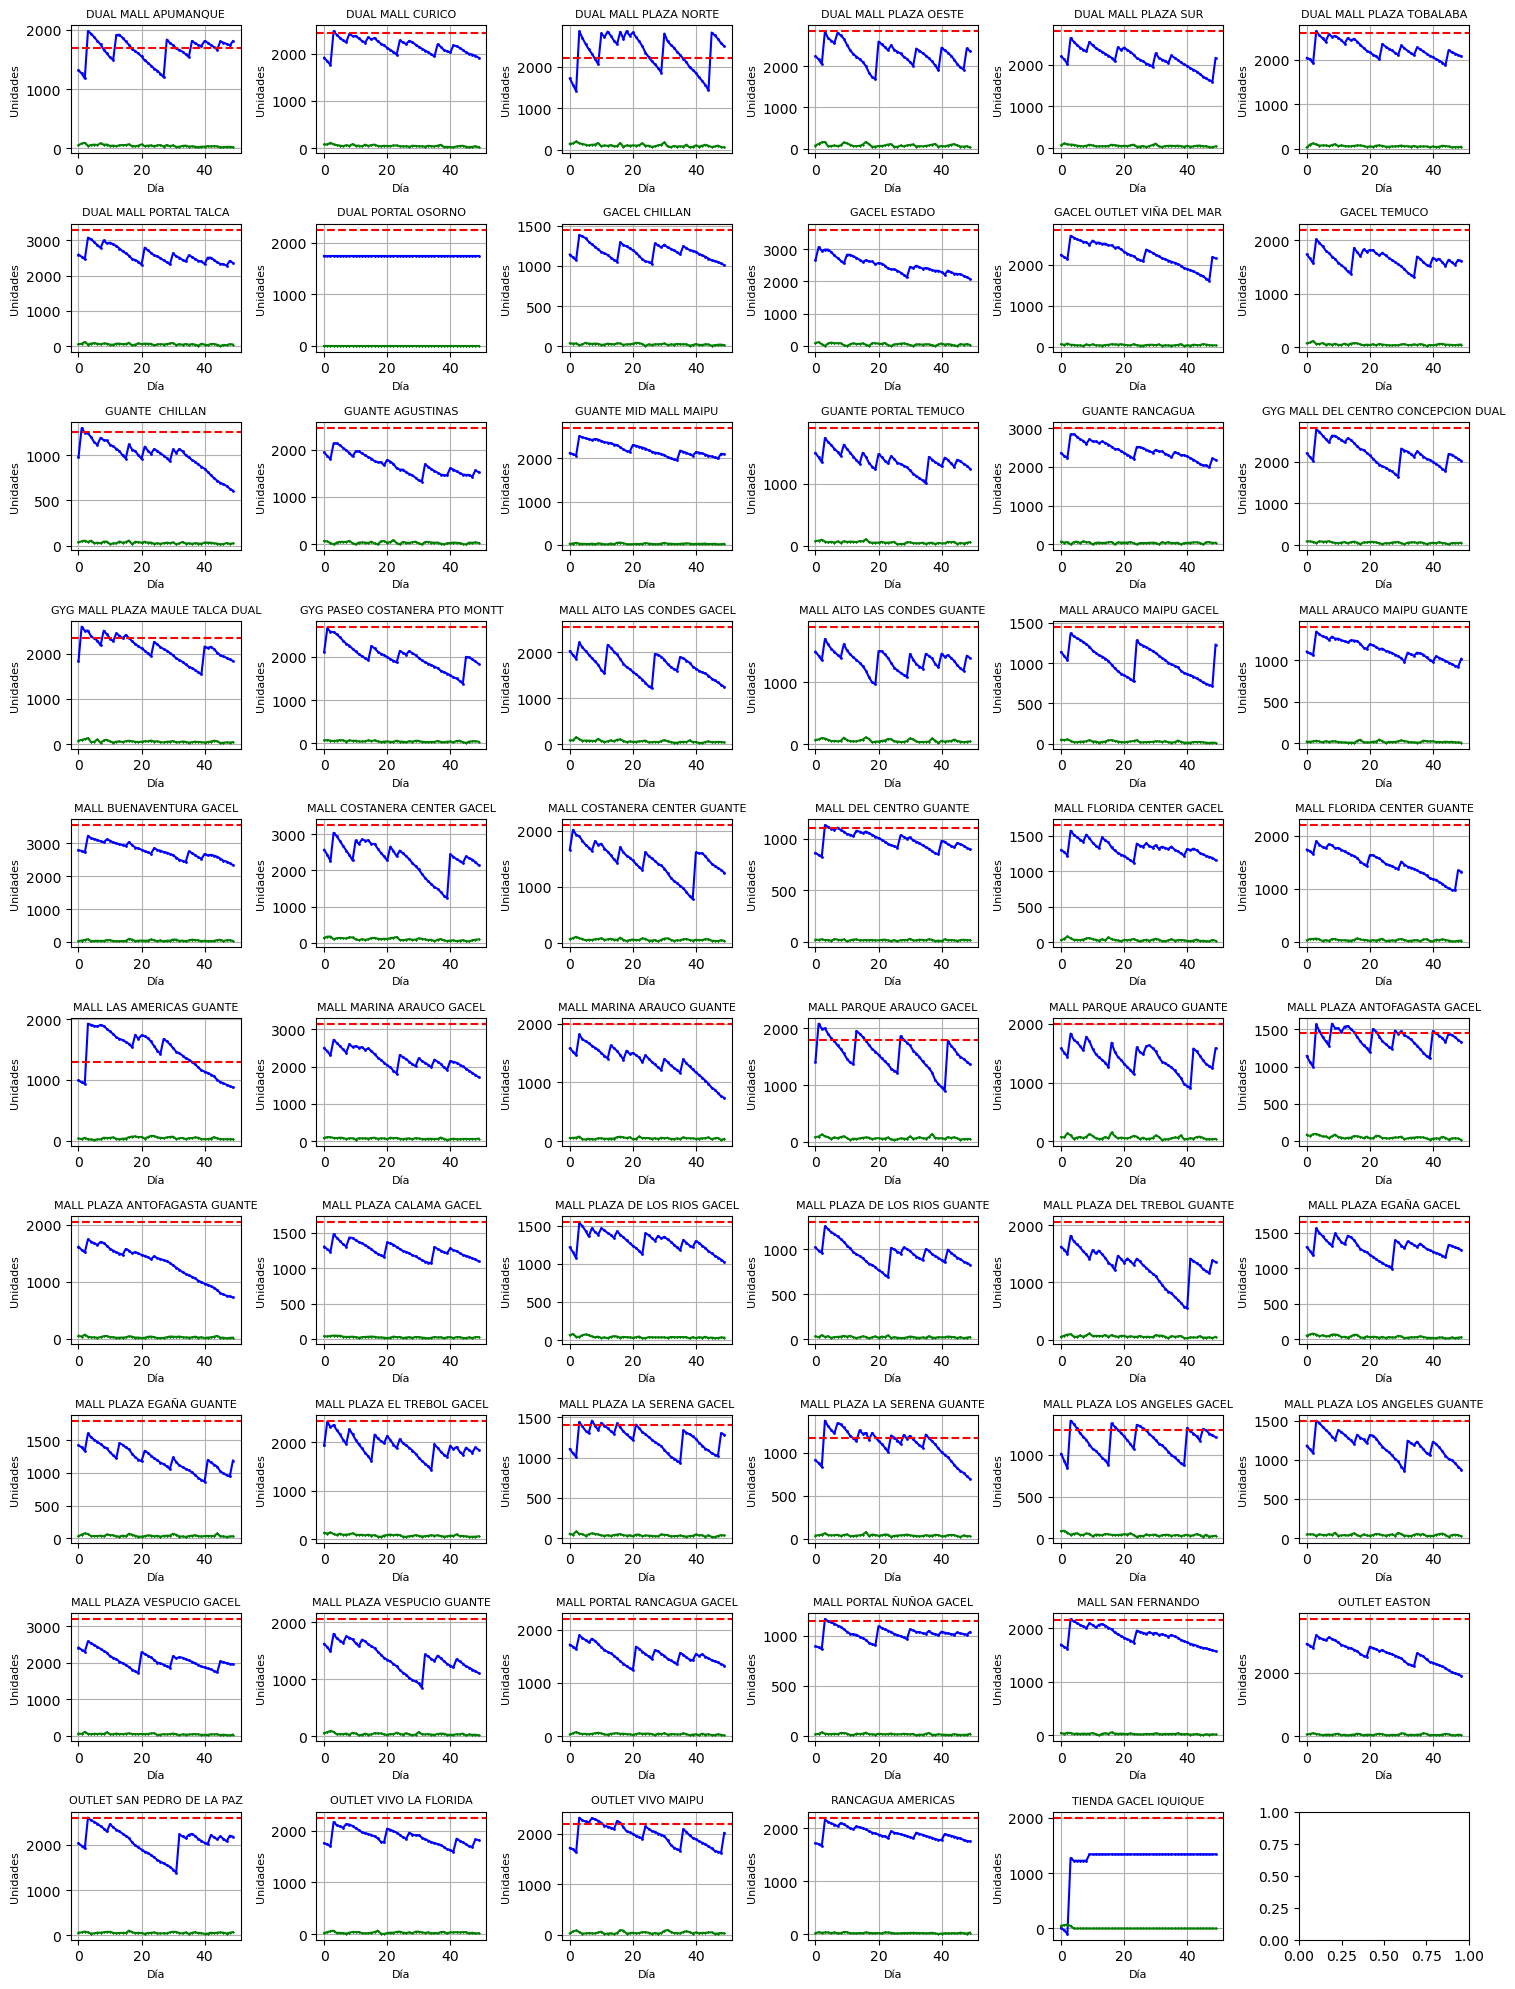

In [ ]:
# Crear la figura y los subgráficos
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 20))

# Aplanar el array de ejes para acceder a cada uno más fácilmente
axes = axes.flatten()

# Iterar sobre cada tienda y crear el gráfico correspondiente
for idx, local in enumerate(locales):
    # Obtener el stock diario para ese cliente de stock_df
    stock_local = stock_df.loc[stock_df['Cliente'] == local].iloc[0, 1:].values  # Accedemos a la fila y las columnas (sin la primera columna)

    # Obtener la capacidad de ese local desde el DataFrame L
    capacidad_local = L[L['Cliente'] == local]['Capacidad'].values[0]

    # Crear los ejes (días del periodo)
    dias = np.arange(periodo)

    # Filtrar las ventas para el cliente específico en forecast
    ventas_local = forecast[forecast['Cliente'] == local]
    ventas_local_diarias = np.zeros(periodo)

    # Sumar las ventas por día (t)
    for t in dias:
        ventas_local_diarias[t] = ventas_local[ventas_local['t'] == t]['Uns'].sum()

    # Seleccionar el subgráfico correspondiente
    ax = axes[idx]

    # Graficar Stock Diario
    ax.plot(dias, stock_local[:-1], label='Stock Diario', color='b', marker='o', markersize=1)

    # Línea de Capacidad Máxima
    ax.axhline(capacidad_local, color='r', linestyle='--', label='Capacidad Máxima')

    # Graficar Ventas Diarias
    ax.plot(dias, ventas_local_diarias, label='Ventas Diarias', color='g', marker='x', markersize=1)

    # Configurar el título y etiquetas
    ax.set_title(f"{local}", fontsize=8)
    ax.set_xlabel("Día", fontsize=8)
    ax.set_ylabel("Unidades", fontsize=8)
    #ax.legend(fontsize=8)
    ax.grid(True)

# Ajustar el diseño para que no se superpongan los subgráficos
plt.tight_layout()
plt.savefig("grafico_genetico.png", dpi=300, bbox_inches='tight')
# Mostrar la figura
plt.show()